In [24]:
# import all libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_predict
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_selection import SelectKBest, f_classif

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('recipe_site_traffic_2212.csv')

df.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

# **DATA VALIDATION**

**Recipe** - numeric, all unique. Matched data details and no missing data. No cleaning required.

**Category** - Category type. had an extra type called "Chicken Breast". Converted "Chicken Breast" to "Chicken". No missing data. This step took place BEFORE filling in the NA values for the other columns. 

**Calories** - numeric. Missing 52 values. Filled in NA with median values grouped by Category type and serving size.

**Carbohydrate** - numeric. Missing 52 values. Filled in NA with median values grouped by Category type and serving size.

**Protein** -  numeric. Missing 52 values. Filled in NA with median values grouped by Category type and serving size.

**Sugar** -  numeric. Missing 52 values. Filled in NA with median values grouped by Category type and serving size.

**Servings** - No missing data. It is in "object" format. Some values had "as a snack" attached. Removed those text values and then converted to int dtype.

**High_traffic** - Missing 373 values. Values were either "High" or NA. Filled NA with "Not High"

In [25]:
df.high_traffic = df.high_traffic.fillna('Not High')
df['category'] = df['category'].replace('Chicken Breast', 'Chicken')
df['servings'] = df['servings'].str.replace(' as a snack', '').astype(int)

def fill_missing(cat):
    df[cat] = df.groupby(['category','servings'])[cat].transform(lambda x: x.fillna(x.median()))

for x in ['calories', 'carbohydrate', 'sugar', 'protein']:
    fill_missing(x)
df.isna().sum()

recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

# **EXPLORATORY DATA ANALYSIS**

Figure 1 breaks down the different type of recipes based on **Category**. Chicken makes up the most amount of recipes at a count of 172 followed by Breakfast at 106, then Beverages at 92.

Figure 2 looks at the typical **Calories** that are in our recipes. 50% of the recipes are between 114 to 576 calories.

Figure 3 looks for any relationship between the nutritional values of our recipes against the website traffic that it produced. It does not seem that there was any correlation found according to that metric.

Figure 4 looks for any patterns in the relationship between traffic generated and the type of recipe. We found that the top three generators of traffic for our website was pork, vegetables, and potatoes.

I then created a new column that tried to fit each recipe to a specific type of diet since diet fads are popular these days. However I was missing a key component of "Fat" so I based it on the percentages of carbohydrates, protein, and sugar.

Figure 5 shows that a majority of our recipes could be considered part of the Mediterranean or DASH type of diet. 

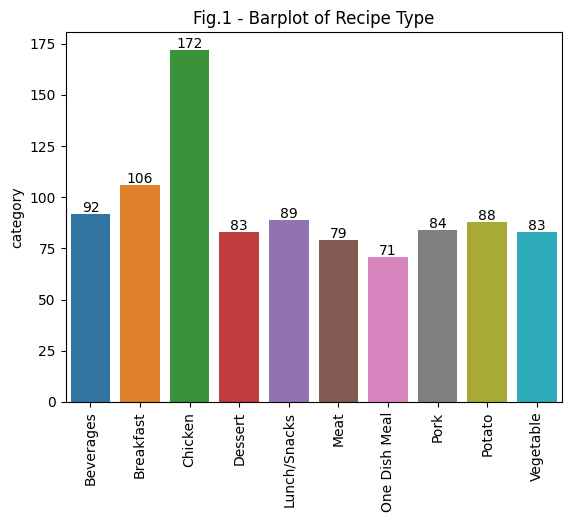

In [26]:
df_sorted = df.sort_values('category')
ax = sns.barplot(x=df_sorted.category.unique(), y=df_sorted.groupby('category')['category'].count())

ax.set(title = 'Fig.1 - Barplot of Recipe Type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

for i, v in enumerate(df_sorted.groupby('category')['category'].count()):
    ax.text(i, v+1, str(v), ha='center')

count     947.000000
mean      432.100676
std       441.604401
min         0.140000
25%       113.905000
50%       299.320000
75%       576.635000
max      3633.160000
Name: calories, dtype: float64


[Text(0.5, 1.0, 'Fig.2 - Boxplot of Calories by Category'),
 Text(0, 0.5, 'Calories'),
 Text(0.5, 0, 'Category')]

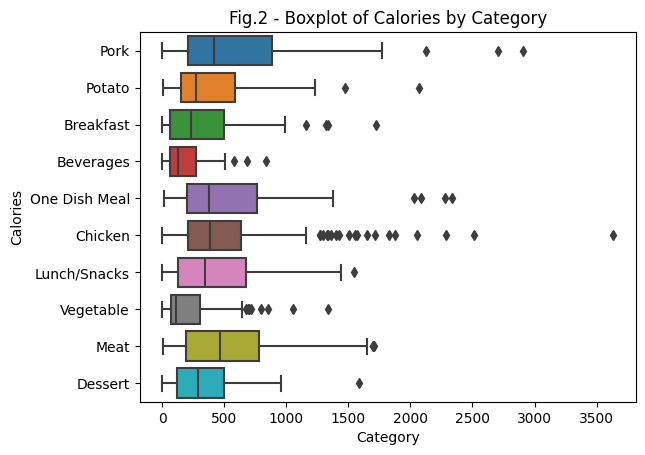

In [27]:
print(df.calories.describe())
ax = sns.boxplot(x=df.calories, y=df.category)
ax.set(title='Fig.2 - Boxplot of Calories by Category', ylabel='Calories', xlabel='Category')

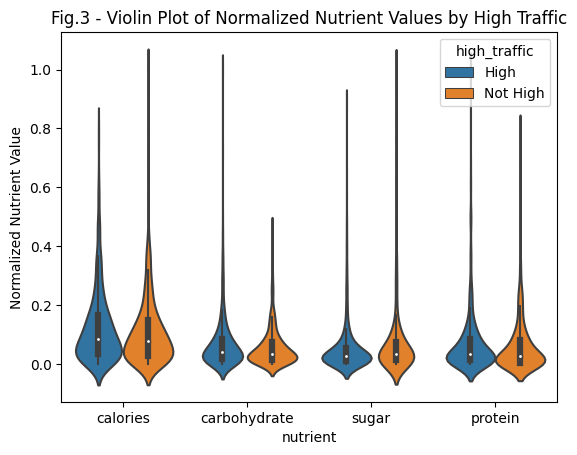

In [28]:
normalized_df = pd.DataFrame()
cols = ['calories', 'carbohydrate', 'sugar', 'protein']

# Normalize columns
for col in cols:
    normalized_col = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    normalized_df[col] = normalized_col

normalized_df['high_traffic'] = df['high_traffic']
melted_df = normalized_df.melt(id_vars='high_traffic', value_vars=cols, var_name='nutrient')

ax = sns.violinplot(x='nutrient', y='value', hue='high_traffic', data=melted_df)
ax.set(title='Fig.3 - Violin Plot of Normalized Nutrient Values by High Traffic', ylabel='Normalized Nutrient Value')

plt.show()  # to display the plot

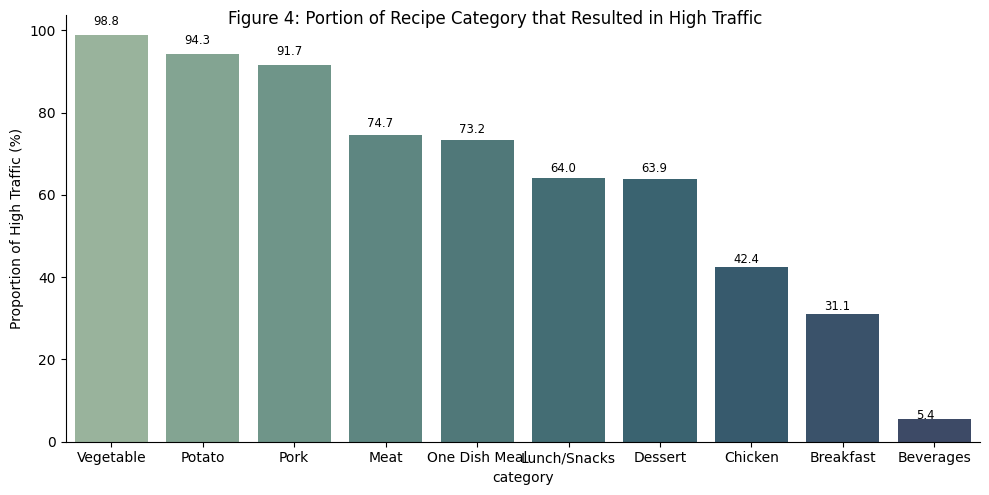

In [29]:
# encode high_traffic , High = 1
df['high_traffic'] = df['high_traffic'].map({'High': 1, 'Not High': 0})

# create the summary table of proportions
temp = df.groupby("category")["high_traffic"].value_counts(normalize = True)
temp = pd.DataFrame(temp).rename(columns={"high_traffic": "prop"})
temp = temp.reset_index()

temp.columns = ['category', 'high_traffic', 'prop']
temp.prop = temp.prop.mul(100)
temp = temp[temp.high_traffic == 1]
temp = temp.sort_values("prop", ascending=False).reset_index()

%matplotlib inline

# create the x-axis sort order
recipe_order = list(temp["category"])

# plot the turnover rates by department
p = sns.catplot(x="category", y="prop", data=temp, order = recipe_order, kind="bar", 
                height=5, aspect=2, saturation=0.5, palette="crest")
p.set_axis_labels("category", "Proportion of High Traffic (%)")
#p.fig.subplots_adjust(top=0.9)
p.fig.suptitle("Figure 4: Portion of Recipe Category that Resulted in High Traffic");

# extract the matplotlib axes_subplot objects from the FacetGrid
ax = p.facet_axis(0,0)
# iterate through the axes patches
for pat in ax.patches:
    ax.text(pat.get_x() + 0.2, 
            pat.get_height() * 1.025, 
           '{0:.1f}'.format(pat.get_height()),
            color='black', 
            rotation = 'horizontal', 
            size = 'small')


# Feature Engineering

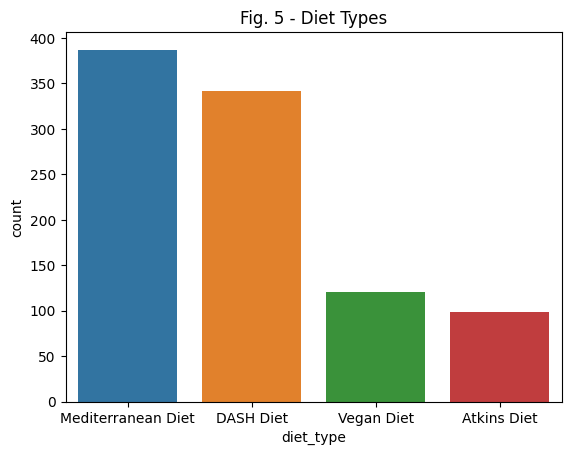

In [30]:
# calculate the total grams for each macronutrient
df['total_grams'] = df['carbohydrate'] + df['sugar'] + df['protein']

# calculate the macronutrient percentages based on grams
df['carb_percent'] = df['carbohydrate'] / df['total_grams'] * 100
df['sugar_percent'] = df['sugar'] / df['total_grams'] * 100
df['protein_percent'] = df['protein'] / df['total_grams'] * 100

# create a new column 'diet_type' based on the macronutrient percentages
df.loc[df['carb_percent'] < 10, 'diet_type'] = 'Atkins Diet'
df.loc[(df['carb_percent'] >= 10) & (df['protein_percent'] >= 20), 'diet_type'] = 'Paleo Diet'
df.loc[(df['carb_percent'] >= 10) & (df['protein_percent'] < 20), 'diet_type'] = 'Mediterranean Diet'
df.loc[(df['carb_percent'] >= 45) & (df['protein_percent'] >= 20), 'diet_type'] = 'Vegan Diet'
df.loc[(df['carb_percent'] >= 10) & (df['carb_percent'] <= 30) & (df['protein_percent'] >= 20), 'diet_type'] = 'Modified Atkins Diet'
df.loc[(df['carb_percent'] >= 10) & (df['carb_percent'] <= 40) & (df['protein_percent'] >= 20), 'diet_type'] = 'Zone Diet'
df.loc[(df['carb_percent'] >= 10) & (df['carb_percent'] <= 50) & (df['protein_percent'] >= 15) & (df['sugar_percent'] <= 10), 'diet_type'] = 'Ketogenic Diet'
df.loc[(df['carb_percent'] >= 10) & (df['carb_percent'] <= 55) & (df['protein_percent'] >= 15), 'diet_type'] = 'DASH Diet'

# drop the newly created columns that were only created for diet_type
df.drop(['carb_percent','sugar_percent','protein_percent'], axis = 1, inplace = True)


# count the occurrences of each diet type
grouped_df = df['diet_type'].value_counts().reset_index()

# rename the columns
grouped_df.columns = ['diet_type', 'count']

# create bar plot
sns.barplot(x='diet_type', y='count', data=grouped_df)

plt.title('Fig. 5 - Diet Types')

# show the plot
plt.show()

# **MODEL DEVELOPMENT**

This is a binary classification problem. We tried a number of different number of classifiers to see which would be best suited for this problem.  One of the classifiers we used was a CatBoost so we created a Pool train and test set to further optimize it.

Each classifier was run through a pipeline that scaled the numerical columns and one hot encoded the categorical columns.

After running through all the classifiers, we determined that CatBoost, Logistic Regression, and SVC (Support Vector Classification) performed the best using a measure of "Accuracy." Those three were selected for further hyperparameter tuning.

Performing the hyperparameter tuning boosted the metrics of all three classifiers with all coming in equal in terms of performance. Precision was 79.4%, Recall 78%, Accuracy at 74%, and F1 score at 78.7%.  Since the metric was to see which would result in high results 80% of the time AND minimize the chance of showing an unpopular recipe; I believe we've achieved this goal with PRECISION rounding up to 80%. Precision is when we want to minimize the amount of false positives in our model.

In [31]:
# split target column from features
X = df.drop(['high_traffic','recipe'], axis=1)
y = df.high_traffic

# instantiate the label encoder and transform the y column
y_enc = LabelEncoder().fit_transform(y)
y_enc = pd.Series(y_enc).astype('category')
y_enc.rename('high_traffic', inplace=True)


X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.3, stratify = y_enc, random_state=22)

#for cat boosting
categorical_feature_indices = np.where(X.dtypes == object)[0]
pool_train = Pool(X_train, y_train, cat_features = categorical_feature_indices)
pool_test = Pool(X_test, y_test, cat_features = categorical_feature_indices)

In [32]:
classifiers = [LogisticRegression(random_state=42),
               SVC(random_state=42, probability=True),
               KNeighborsClassifier(),
               GaussianNB(),
               GradientBoostingClassifier(random_state=42),
               XGBClassifier(random_state=42),
               DecisionTreeClassifier(random_state=42),
               AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42),
               ExtraTreesClassifier(random_state=42),
               RandomForestClassifier(random_state=42),
               CatBoostClassifier(random_state=42)]


# Preprocessing step of pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), make_column_selector(dtype_include=np.number)),
    ('cat', OneHotEncoder(), make_column_selector(dtype_include=object))])

# Define the feature selection step of pipeline
rfe_clf = RandomForestClassifier(n_estimators=100, random_state=42)
feat_selection = SelectFromModel(rfe_clf)

results_df = pd.DataFrame()

for clf in classifiers:
    if isinstance(clf, CatBoostClassifier):
        pipeline = make_pipeline(clf)
        clf.set_params(verbose=False)
        pipeline.fit(pool_train)
        y_pred = pipeline.predict(pool_test)
        y_prob = pipeline.predict_proba(pool_test)[:, 1]
    
    else:
        pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feat_selection', feat_selection),
        ('clf', clf)
        ])
        pipeline.fit(X_train, y_train)

        selected_features = pipeline.named_steps['preprocessor'].get_feature_names_out()   [pipeline.named_steps['feat_selection'].get_support(indices=True)]
        selected_features = [feature.split('__', 1)[1] if '__' in feature else feature for feature in selected_features]
    
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1]
        
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    #roc scores
    auc_roc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    #precision - recall curve data
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    test_precisions, test_recalls, _ = precision_recall_curve(y_test, y_prob)
    
    # confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    false_positives = fp / (fp + tn)
    false_negatives = fn / (fn + tp)
    
    results_df = results_df.append({'Model': clf.__class__.__name__,
                                    'Recall': recall,
                                    'Precision': precision,
                                    'Accuracy': accuracy,
                                    'F1': f1,
                                    'AUC-ROC': auc_roc,
                                    'False Positives': false_positives,
                                    'False Negatives': false_negatives,
                                    'FPR':fpr,
                                    'TPR':tpr,
                                    'test_precisions':test_precisions,
                                    'test_recalls':test_recalls,
                                    'Selected Features': selected_features,
                                    'Number of Features': len(selected_features)}, ignore_index=True)

results_df.iloc[:,:8].sort_values('Accuracy', ascending = False)

,Model,Recall,Precision,Accuracy,F1,AUC-ROC,False Positives,False Negatives
1,SVC,0.924855,0.720721,0.736842,0.810127,0.687061,0.553571,0.075145
3,GaussianNB,0.913295,0.724771,0.736842,0.808184,0.684429,0.535714,0.086705
10,CatBoostClassifier,0.791908,0.778409,0.736842,0.785100,0.821816,0.348214,0.208092
0,LogisticRegression,0.919075,0.719457,0.733333,0.807107,0.737330,0.553571,0.080925
9,RandomForestClassifier,0.843931,0.726368,0.712281,0.780749,0.729846,0.491071,0.156069
8,ExtraTreesClassifier,0.815029,0.734375,0.708772,0.772603,0.726311,0.455357,0.184971
4,GradientBoostingClassifier,0.861272,0.712919,0.705263,0.780105,0.701615,0.535714,0.138728
5,XGBClassifier,0.791908,0.709845,0.677193,0.748634,0.709202,0.500000,0.208092
2,KNeighborsClassifier,0.797688,0.704082,0.673684,0.747967,0.705538,0.517857,0.202312
6,DecisionTreeClassifier,0.716763,0.733728,0.670175,0.725146,0.656327,0.401786,0.283237


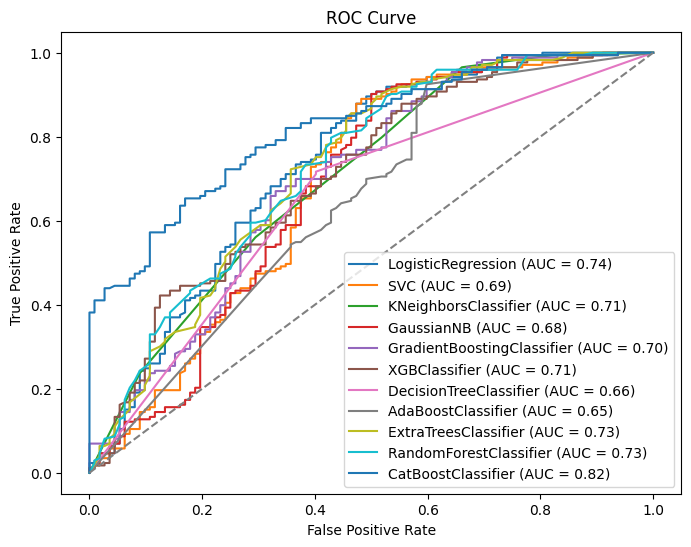

In [33]:
# Visualize performance of models based on auc-roc
def plot_roc_auc(df):
    plt.figure(figsize=(8,6))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

    for model in df['Model'].unique():
        df_model = df[df['Model'] == model]
        roc_auc = df_model['AUC-ROC'].iloc[0]
        fpr = df_model['FPR'].iloc[0]
        tpr = df_model['TPR'].iloc[0]
        plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')
        
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_auc(results_df)

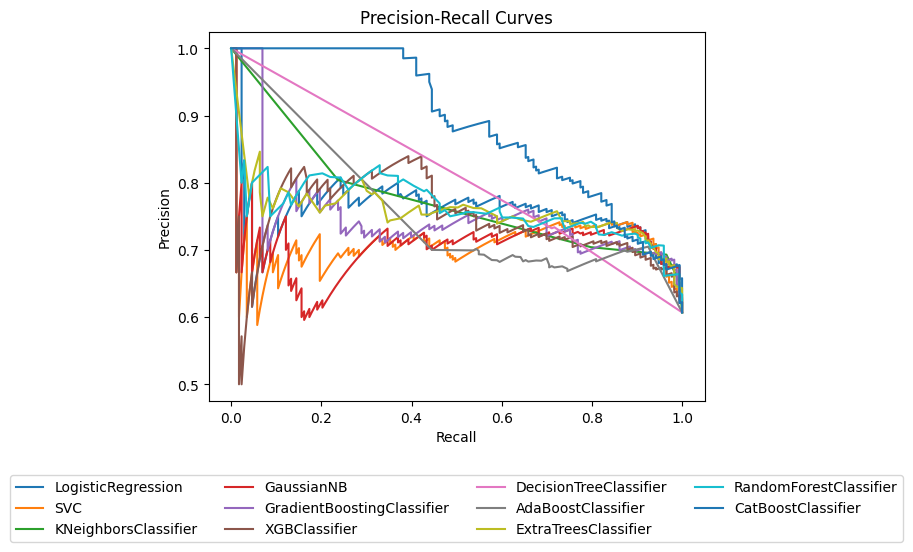

In [34]:
def plot_precision_recall_curves(model_results):
    for i, row in model_results.iterrows():
        model_name = row['Model']
        test_precisions = row['test_precisions']
        test_recalls = row['test_recalls']
        plt.plot(test_recalls, test_precisions, label=model_name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(ncol=4, loc='lower center', bbox_to_anchor=(0.5, -0.4))
    plt.show()
    
plot_precision_recall_curves(results_df)

# Hyperparameter Tuning

In [35]:
# Hyperparameter tuning on top 3 models based on Accuracy
feat_selection = SelectKBest(f_classif, k=5)

# Define grid search parameters for SVC
svc_param_grid = {
    'clf__C': np.logspace(-3, 3, num=7),
    'clf__kernel': ['linear', 'rbf', 'poly'],
    'clf__degree': [2, 3, 4],
    'clf__gamma': ['scale', 'auto'] + list(np.logspace(-3, 2, num=6)),
}


# Define grid search parameters for Logistic Regression
logreg_param_grid = {
    'clf__C': np.logspace(-3, 3, num=7),
    'clf__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'clf__max_iter': [100, 1000, 10000],
    'clf__l1_ratio': [0.25, 0.5, 0.75],
}

# Define grid search parameters for CatBoost
catboost_param_grid = {
    'clf__iterations': [100, 500],
    'clf__learning_rate': [0.01, 0.1, 0.5],
    'clf__depth': [3, 5, 7],
    'clf__l2_leaf_reg': [1, 3, 5],
}



# List of classifiers and their respective hyperparameter grids
classifiers = [
    {'name': 'SVC', 'clf': SVC(), 'param_grid': svc_param_grid},
    {'name': 'LogisticRegression', 'clf': LogisticRegression(), 'param_grid': logreg_param_grid},
    {'name': 'CatBoost', 'clf': CatBoostClassifier(verbose=False), 'param_grid': catboost_param_grid}
]

In [36]:
# Results dataframe initialization
results_df2 = pd.DataFrame()

# Iterate through each classifier and perform grid search
for clf_dict in classifiers:
    clf_name = clf_dict['name']
    clf = clf_dict['clf']
    param_grid = clf_dict['param_grid']
    clf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('feat_selection',           feat_selection), ('clf', clf)])
    grid_search = GridSearchCV(clf_pipeline, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print("Best hyperparameters for", clf_name + ":", best_params)
    
    # Evaluate best model
    best_model = clf_pipeline.set_params(**best_params)
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    auc_roc = roc_auc_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average="binary")
    precision = precision_score(y_test, y_pred, average="binary")
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="binary")
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    false_positives = fp / (fp + tn)
    false_negatives = fn / (fn + tp)
    
    # Append results to dataframe
    results_df2 = results_df2.append({'Model': clf.__class__.__name__,
                                    'Recall': recall,
                                    'Precision': precision,
                                    'Accuracy': accuracy,
                                    'F1': f1,
                                    'AUC-ROC': auc_roc,
                                    'False Positives': false_positives,
                                    'False Negatives': false_negatives}, ignore_index=True)

results_df2.sort_values('Accuracy', ascending = False)  

Best hyperparameters for SVC: {'clf__C': 0.001, 'clf__degree': 2, 'clf__gamma': 10.0, 'clf__kernel': 'poly'}
Best hyperparameters for LogisticRegression: {'clf__C': 0.001, 'clf__l1_ratio': 0.25, 'clf__max_iter': 100, 'clf__penalty': 'none', 'clf__solver': 'newton-cg'}
Best hyperparameters for CatBoost: {'clf__depth': 3, 'clf__iterations': 100, 'clf__l2_leaf_reg': 1, 'clf__learning_rate': 0.01}


,Model,Recall,Precision,Accuracy,F1,AUC-ROC,False Positives,False Negatives
0,SVC,0.780347,0.794118,0.74386,0.787172,0.733923,0.3125,0.219653
1,LogisticRegression,0.780347,0.794118,0.74386,0.787172,0.733923,0.3125,0.219653
2,CatBoostClassifier,0.780347,0.794118,0.74386,0.787172,0.733923,0.3125,0.219653


# **Business Recommendations**

All three models after hyperparameter tuning performed identical so we will go with Logistic Regression.

As you can see by Fig 6, Beverages has the largest negative coefficient followed by Beverages, Breakfast, and Chicken. 

My recommendation is that we should stop making recipes that are Beverages, Breakfast, and Chicken and focus on increasing Vegetables, Potatos, and Pork if we want to increase the traffic to our website!

In [37]:
X_train.reset_index(inplace=True)

X_train=X_train.drop('index', axis=1)

# Select columns for one-hot encoding
cols_to_encode = ['diet_type', 'category']

# Initialize one-hot encoder
encoder = OneHotEncoder()

# Fit encoder to selected columns and transform them
encoded_cols = pd.DataFrame(encoder.fit_transform(X_train[cols_to_encode]).toarray(), 
                            columns=encoder.get_feature_names_out(cols_to_encode))

# Drop original columns from the dataframe
X_train = X_train.drop(cols_to_encode, axis=1)

# Concatenate the encoded columns with the original dataframe
X_train = pd.concat([X_train, encoded_cols], axis=1)

# Define hyperparameters for logistic regression model
logreg_params = {
    'C': 0.001,
    'l1_ratio': 0.25,
    'max_iter': 100,
    'penalty': 'none',
    'solver': 'newton-cg'
}

# Initialize logistic regression model with hyperparameters
logreg = LogisticRegression(**logreg_params)
# Perform feature selection using L1 regularization
selector = SelectFromModel(logreg)
selector.fit(X_train, y_train)

# Fit logistic regression model to the selected features
selected_features = X_train.columns[selector.get_support()]
logreg.fit(X_train[selected_features], y_train)

# Get selected features and corresponding coefficients
coefficients = logreg.coef_[0]

# Print selected features and their coefficients
for feature, coef in zip(selected_features, coefficients):
    print(feature, coef)

category_Beverages -3.5360577385833034
category_Breakfast -1.8174124123301825
category_Chicken -1.2467462364288047
category_Pork 1.3166297216307006
category_Potato 1.7030294452747445
category_Vegetable 3.2652319336327826


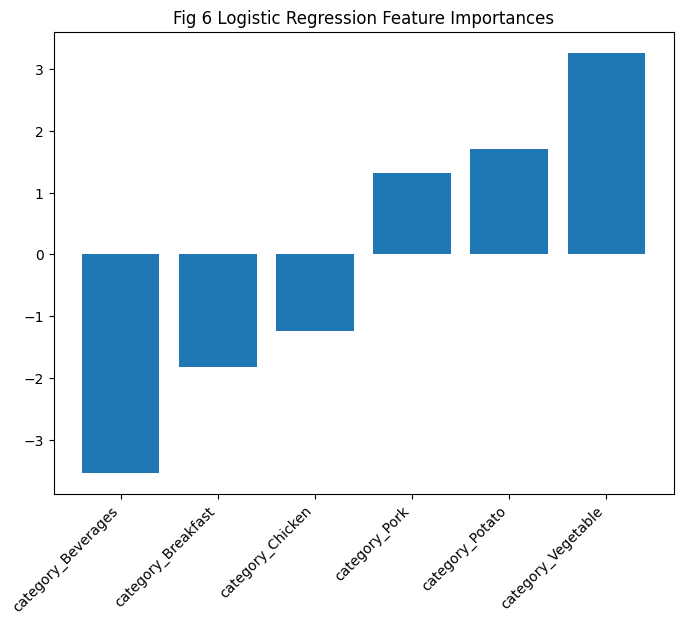

In [38]:
# Plot feature importances
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(np.arange(len(selected_features)), coefficients)
ax.set_xticks(np.arange(len(selected_features)))
ax.set_xticklabels(selected_features, rotation=45, ha='right')
ax.set_title("Fig 6 Logistic Regression Feature Importances")
plt.show()
